# **Imports**

In [ ]:
import matplotlib.pyplot as plt
import random
from skimage.io import imread
import pandas as pd
import cv2
import os
from os import listdir
import tensorflow as tf
import numpy as np
import sys
#!pip install PyQt5
from PyQt5.QtWidgets import QApplication, QMainWindow, QSlider, QLabel, QVBoxLayout, QWidget
from PyQt5.QtGui import QPixmap, QImage
import warnings
warnings.filterwarnings("ignore")
import keras
from keras import layers

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# **Loading data**

In [ ]:
x_train=[]
i=0
for images in os.listdir('/content/drive/MyDrive/cat'):
    img = cv2.cvtColor(cv2.imread(("/content/drive/MyDrive/cat//" +images)), cv2.COLOR_BGR2RGB)

    if(type(img) == type(None) or len(img.shape) !=3 or img.shape[2]!=3):
      pass
    else:
      resized = cv2.resize(img, (256,256), interpolation = cv2.INTER_AREA)
      normalize=(np.asarray(resized).astype('float32')) / 255
      x_train.append(normalize)

In [ ]:
x_train=np.array(x_train)
x_train.shape

(400, 256, 256, 3)

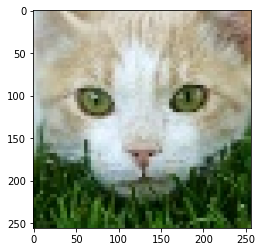

In [ ]:
plt.imshow(x_train[0])

# **Model**

In [ ]:
inputs = keras.Input(shape=(256, 256, 3))
x = layers.Conv2D(64, 3, strides=2,activation='relu',  padding='same')(inputs)
x = layers.Conv2D(64, 3, strides=2,activation='relu',  padding='same')(x)
x = layers.Conv2D(32, 3,  strides=2,activation='relu',  padding='same')(x)

x = layers.Conv2D(32, 3,  strides=2,activation='relu',  padding='same')(x)
x = layers.Flatten()(x)
z_mean = layers.Dense(10)(x)
z_log_sigma = layers.Dense(10)(x)

def sampling(args):
    z_mean, z_log_sigma = args
    epsilon = tf.random.normal(shape=(tf.shape(z_mean)[0], 10),
                              mean=0., stddev=0.1)
    return z_mean + tf.exp(z_log_sigma) * epsilon

z = layers.Lambda(sampling)([z_mean, z_log_sigma])
encoder = keras.Model(inputs, [z_mean, z_log_sigma, z])
encoder.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 64, 64, 64)   36928       ['conv2d[0][0]']                 
                                                                                              

In [ ]:
latent_inputs = keras.Input(shape=(10,))

x = layers.Dense(32 * 32 * 128)(latent_inputs)
x = layers.Reshape((32, 32, 128))(x)
x = layers.Conv2DTranspose(64, 3, activation='relu', strides=2, padding='same')(x)
x = layers.Conv2DTranspose(32, 3, activation='relu', strides=2, padding='same')(x)

x = layers.Conv2DTranspose(8, 3, activation='relu', strides=2, padding='same')(x)

outputs = layers.Conv2DTranspose(3, 3, activation='relu', padding='same')(x)

decoder = keras.Model(latent_inputs, outputs)
decoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 10)]              0         
                                                                 
 dense_2 (Dense)             (None, 131072)            1441792   
                                                                 
 reshape (Reshape)           (None, 32, 32, 128)       0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 64, 64, 64)       73792     
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 128, 128, 32)     18464     
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 256, 256, 8)      2312

In [ ]:
# Define the VAE
outputs = decoder(encoder(inputs)[2])
vae = keras.Model(inputs, outputs)
vae.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 model (Functional)          [(None, 10),              230292    
                              (None, 10),                        
                              (None, 10)]                        
                                                                 
 model_1 (Functional)        (None, 256, 256, 3)       1536579   
                                                                 
Total params: 1,766,871
Trainable params: 1,766,871
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Define the VAE loss
reconstruction_loss = tf.keras.losses.MeanSquaredError()
reconstruction_loss = reconstruction_loss(inputs, outputs)
kl_loss = 1 + z_log_sigma - tf.square(z_mean) - tf.exp(z_log_sigma)
kl_loss = tf.reduce_mean(kl_loss)
kl_loss *= -0.5

loss = reconstruction_loss+kl_loss
vae.add_loss(loss)

vae.compile(optimizer='Adam')

vae.fit(x_train, x_train, epochs=30, batch_size=1)

Epoch 1/30
400/400 [==============================] - 10s 11ms/step - loss: 0.0784
Epoch 2/30
400/400 [==============================] - 4s 11ms/step - loss: 0.0542
Epoch 3/30
400/400 [==============================] - 4s 11ms/step - loss: 0.0479
Epoch 4/30
400/400 [==============================] - 4s 11ms/step - loss: 0.0466
Epoch 5/30
400/400 [==============================] - 3s 8ms/step - loss: 0.0463
Epoch 6/30
400/400 [==============================] - 3s 8ms/step - loss: 0.0453
Epoch 7/30
400/400 [==============================] - 3s 8ms/step - loss: 0.0460
Epoch 8/30
400/400 [==============================] - 3s 8ms/step - loss: 0.0435
Epoch 9/30
400/400 [==============================] - 3s 8ms/step - loss: 0.0438
Epoch 10/30
400/400 [==============================] - 3s 8ms/step - loss: 0.0439
Epoch 11/30
400/400 [==============================] - 3s 8ms/step - loss: 0.0443
Epoch 12/30
400/400 [==============================] - 3s 8ms/step - loss: 0.0426
Epoch 13/30
400/400 

In [ ]:
#dec = decoder(latent_inputs)
decoder.save_weights('weights/dec_29.h5')

decoder.load_weights('weights/dec_29.h5')


In [ ]:
x = np.random.normal(size = (20,10))

x_decoded = decoder.predict(x)

1/1 [==============================] - 0s 286ms/step


In [ ]:
x_decoded.shape

(20, 256, 256, 3)

# **Generation**

IntSlider(value=1, max=12, min=1)

1/1 [==============================] - 0s 104ms/step


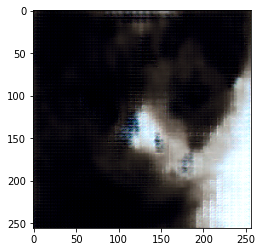

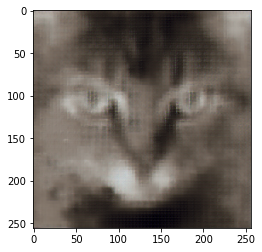

1/1 [==============================] - 0s 218ms/step


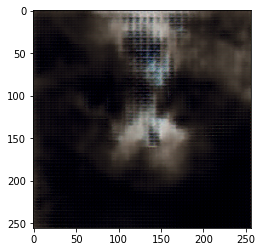

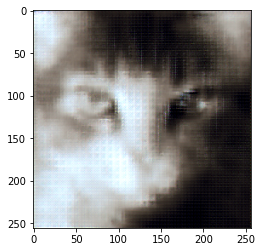

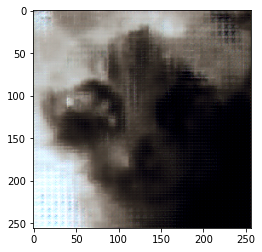

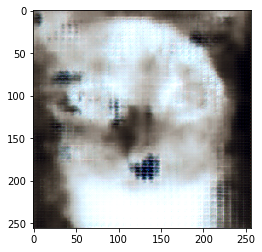

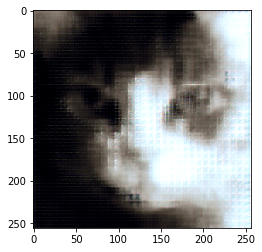

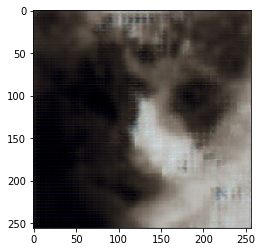

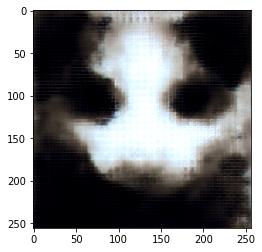

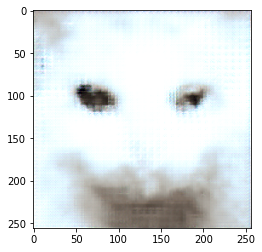

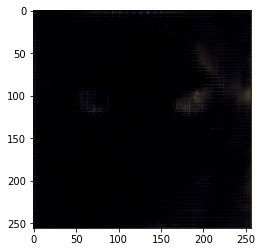

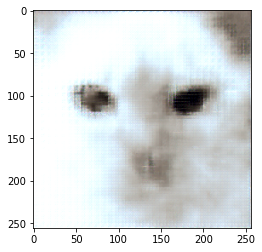

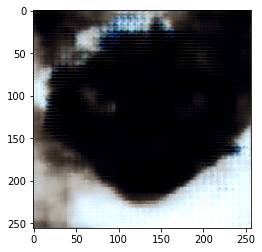

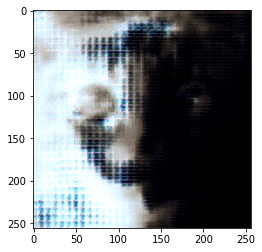

In [ ]:
# Import the necessary libraries
import tkinter as tk
from tkinter import ttk

import random
#!pip install ipywidgets
#!jupyter nbextension enable --py widgetsnbextension
import ipywidgets as widgets

def generate_images(num_images):
  # Generate and display the images using the VAE model
  latent_vectors = np.random.normal(size=(num_images, 10))
  images = decoder.predict(latent_vectors)
  for image in images:
    plt.imshow(image)
    plt.show()

slider = widgets.IntSlider(min=1, max=12, value=1)

def on_slider_change(change):
  num_images = change['new']
  generate_images(num_images)

slider.observe(on_slider_change, names='value')
display(slider)


